# Asymmetric Loss
https://arxiv.org/pdf/2009.14119.pdf

# VAN
https://arxiv.org/pdf/2202.09741.pdf

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from transformers import AutoImageProcessor
from mmpretrain import get_model
import torch.nn.functional as F



c:\Users\User\anaconda3\envs\open-mmlab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
NUM_ATTR = 6
class FashionNet_Dataset(Dataset):

    def __init__(self, root, txt, dataset: str,
                 #train_mean = torch.tensor([0.7660162448883057, 0.7361660003662109, 0.725688099861145]), train_std = torch.tensor([0.08105689287185669, 0.08844506740570068, 0.09216779470443726])
                 ):
        self.img_path = []
        self.labels = [[] for _ in range(NUM_ATTR)]

        self.preprocess = AutoImageProcessor.from_pretrained("Visual-Attention-Network/van-tiny")
        self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomRotation(degrees = 20),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05)
            ])
        self.dataset = dataset
        

        with open(txt) as f:
            for line in f:
                self.img_path.append(os.path.join(root, line.split()[0]))
                # make dummy label for test set
                if 'test' in txt:
                    for i in range(NUM_ATTR):
                        self.labels[i].append(0)
        if 'test' not in txt:
            with open(txt.replace('.txt', '_attr.txt')) as f:
                for line in f:
                    attrs = line.split()
                    for i in range(NUM_ATTR):
                        self.labels[i].append(int(attrs[i]))

    def __len__(self):
        return len(self.labels[0])
    


    def __getitem__(self, index):

        path = self.img_path[index]
        label = np.array([self.labels[i][index] for i in range(NUM_ATTR)])

        with open(path, 'rb') as f:
            sample = Image.open(f).convert('RGB')

            if self.dataset == 'train':
                sample = self.transform(sample)
                
            sample = self.preprocess(sample)

        ...
        
        return sample, label, index
   


In [5]:
trainset = FashionNet_Dataset("FashionDataset/FashionDataset", txt = 'FashionDataset/FashionDataset/split/train.txt', dataset = 'train')
valset = FashionNet_Dataset("FashionDataset/FashionDataset", txt = 'FashionDataset/FashionDataset/split/val.txt', dataset = 'val')
testset = FashionNet_Dataset("FashionDataset/FashionDataset", txt = 'FashionDataset/FashionDataset/split/test.txt', dataset = 'test')

print(f"Number of training data: {len(trainset)} || Number of val data: {len(valset)} || Number of test data: {len(testset)}")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be remo

Number of training data: 5000 || Number of val data: 1000 || Number of test data: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


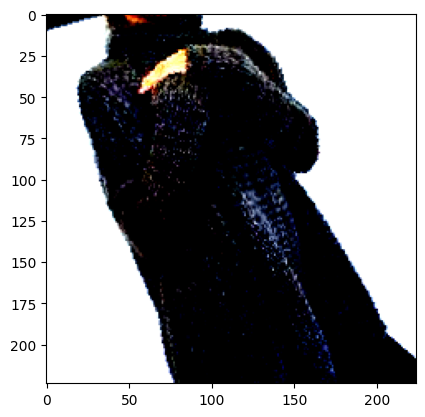

In [6]:
img = trainset.__getitem__(1)[0]
image_data = np.asarray(img['pixel_values'][0])

print(image_data.shape)

plt.imshow(image_data.transpose(1,2,0))

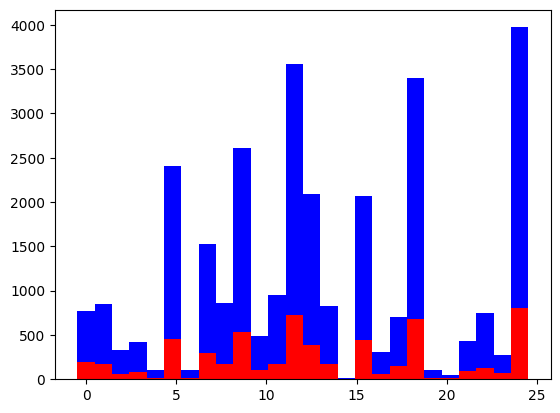

In [7]:
#Count attributes of dataset 
def count_attrs(dataset: FashionNet_Dataset):
    attrs = {k: 0 for k in range(26)}
    num_classes = [7, 3, 3, 4, 6, 3]  # number of classes in each attribute

    for i in range(len(dataset)):
        for c, attr in enumerate(dataset.__getitem__(i)[1]):
            
            if  c == 0:
                idx = attr     
            else:
                idx =  attr + sum(num_classes[:c])
                #print(c, idx)
            attrs[idx] += 1
                
    return attrs

#Visualization of imbalance
train_attrs = count_attrs(trainset)
val_attrs = count_attrs(valset)

plt.hist(x = train_attrs.keys(), bins = 26, weights = train_attrs.values(), align = 'left', color = 'blue')
plt.hist(x = val_attrs.keys(), bins = 26, weights = val_attrs.values(), align = 'left', color = 'red')
plt.show()

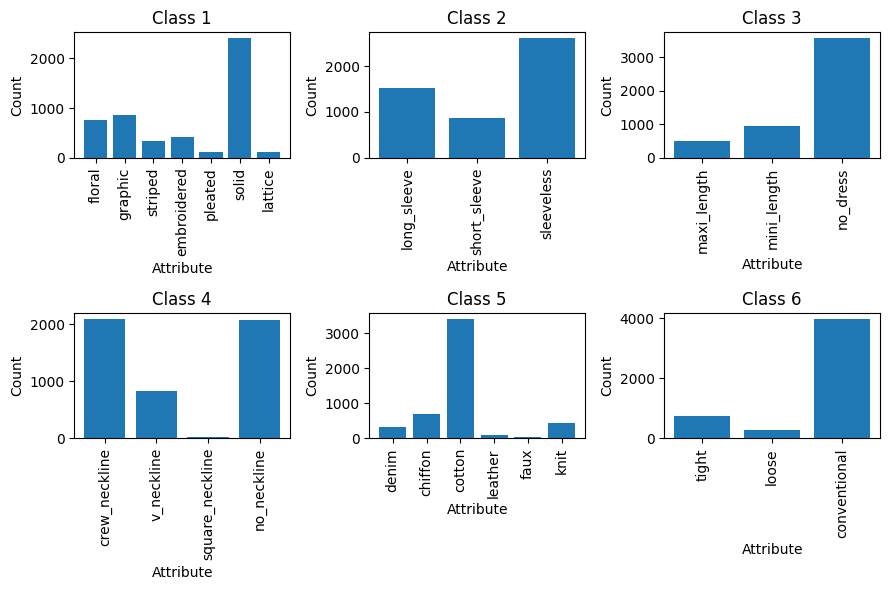

In [8]:
def plot_class_distribution(data):
  num_attr = 6
  num_classes = [7, 3, 3, 4, 6, 3]  # number of classes in each attribute
  classes =  [
      ['floral', 'graphic', 'striped', 'embroidered', 'pleated', 'solid', 'lattice'], \
      ['long_sleeve', 'short_sleeve', 'sleeveless'], \
      ['maxi_length', 'mini_length', 'no_dress'], \
      ['crew_neckline', 'v_neckline', 'square_neckline', 'no_neckline'], \
      ['denim', 'chiffon', 'cotton', 'leather', 'faux', 'knit'], \
      ['tight', 'loose', 'conventional']
      ]
  y_s = [np.zeros(i) for i in num_classes]
  for _, (_,labels,_) in enumerate(data):
    for i in range(num_attr):
        y_s[i][labels[i]] += 1
  fig = plt.figure(figsize=(9, 6))
  for i in range(num_attr):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.bar(range(num_classes[i]), y_s[i])
    ax.set_xticks(range(num_classes[i]))
    ax.set_xticklabels(classes[i], rotation=90)
    ax.set_title(f"Class {i + 1}")
    ax.set_ylabel("Count")
    ax.set_xlabel("Attribute")
  plt.tight_layout()
  plt.show()

plot_class_distribution(trainset)

In [9]:
#Load into Dataloader for mini-batch training
batch_size = 64

train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(valset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(testset, batch_size = batch_size, shuffle = False) 

print(f"Number of minibatches for train_loader: {len(train_loader)} || Number of minibatches for val_loader: {len(val_loader)}")

Number of minibatches for train_loader: 79 || Number of minibatches for val_loader: 16


In [10]:
# #Function for normalization
# def get_mean_and_std(train: FashionNet_Dataset):
#     sum = [0]*3
#     sqrd_sum = [0]*3
    
#     for i in range(len(train)):
#         img = train.__getitem__(i)[0]
#         for channel in range(3):
#             sum[channel] += torch.sum(img[channel])
#             sqrd_sum[channel] += torch.sum(img[channel]**2)
    

#     mean, std = [0]*3, [0]*3
#     for channel in range(3):
#         mean[channel]= (sum[channel]/(len(train)*256*256)).item()
#         std[channel ]= (sqrd_sum[channel]/(len(train)*256*256) - mean[channel]**2).item()

#     return mean, std

# train_mean, train_std = get_mean_and_std(trainset)


# Setting up Models

In [11]:
class VAN_PT(nn.Module):
    def __init__(self, finetune):
        super(VAN_PT, self).__init__()
        self.extractor = get_model('van-tiny_3rdparty_in1k', pretrained=True)
        self.extractor.name = "VAN_PT"
        
        if not finetune:
            for param in self.extractor.parameters():
                param.requires_grad = False

In [12]:
import torch.nn.functional as F

class DenseClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes:list):
        super(DenseClassifier, self).__init__()
      
    
        self.hidden_layer = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                          nn.Dropout(p=0.3),
                                          nn.Linear(hidden_dim, hidden_dim*2),
                                          nn.Dropout(p=0.3),
                                          nn.Linear(hidden_dim*2, hidden_dim))
        
        self.output_layer = nn.ModuleList([nn.Linear(hidden_dim, i) for i in num_classes])

    def forward(self, x):
        outputs = []
        for hidden_layer in self.hidden_layer:
            x = F.relu(hidden_layer(x))
        for layer in self.output_layer:
            outputs.append(F.softmax(layer(x), dim = 1))
        outputs = torch.cat(outputs, dim=1)
        return outputs


In [13]:
#Weights for criterion
# train_weights = []
# total_count = len(trainset) * 6

# for v in train_attrs.values():
#     train_weights.append(total_count/v)

# train_weights = torch.tensor(train_weights, requires_grad=False)
    

# Define Loss


In [14]:
# class diceloss(torch.nn.Module):
#     def init(self):
#         super(diceloss, self).init()
#     def forward(self,pred, target):
#        smooth = 1.
#        iflat = pred.contiguous().view(-1)
#        tflat = target.contiguous().view(-1)
#        intersection = (iflat * tflat).sum()
#        A_sum = torch.sum(iflat * iflat)
#        B_sum = torch.sum(tflat * tflat)
#        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [15]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        xs_pos = x
        xs_neg = 1 - x

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation        
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


# Define model

In [16]:
#Define model and hyperparameters
epochs = 100
device = 'cuda'
extractor = VAN_PT(finetune=True).extractor.to(device)
classifier = DenseClassifier(input_dim = 256, hidden_dim = 100, num_classes = [7, 3, 3, 4, 6, 3]).to(device)

optimizer = torch.optim.Adam([param for param in extractor.parameters()] + [param for param in classifier.parameters()], lr=5e-4, weight_decay=0.0003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = AsymmetricLoss().to(device)


def count_params(model, grad = True):
    if grad:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

print(f"Number of trainable parameters in the model: {count_params(extractor, grad = True) + count_params(classifier, grad = True):,}")
print(f"Total number of parameters: {count_params(extractor, grad = False) + count_params(classifier, grad = False):,}")


03/29 11:27:51 - mmengine - INFO - Because batch augmentations are enabled, the data preprocessor automatically enables the `to_onehot` option to generate one-hot format labels.


c:\Users\User\anaconda3\envs\open-mmlab\lib\site-packages\mmcv\cnn\bricks\transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv`` rather than ``mmcv-lite`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmclassification/v0/van/van-tiny_8xb128_in1k_20220501-385941af.pth
Number of trainable parameters in the model: 4,174,426
Total number of parameters: 4,174,426


In [17]:
# evaluation
def compute_avg_class_acc(gt_labels, pred_labels):      #gt_labels = [64, 6] = pred_labels
    num_attr = 6
    num_classes = [7, 3, 3, 4, 6, 3]  # number of classes in each attribute

    per_class_acc = []
    for attr_idx in range(num_attr):
        for idx in range(num_classes[attr_idx]):
            target = gt_labels[:, attr_idx]
            pred = pred_labels[:, attr_idx]
            correct = np.sum((target == pred) * (target == idx))
            total = np.sum(target == idx)
            
            if total != 0:
                per_class_acc.append(float(correct) / float(total))

    return sum(per_class_acc) / len(per_class_acc)

In [18]:
#Function to change into one-hot encoding for each output
def transform_oh(target: torch.tensor) -> torch.tensor:
    num_classes = [7, 3, 3, 4, 6, 3]  # number of classes in each attribute
    target1 = []
    for batch in range(target.size(0)):
        indiv_target = target[batch]
        indiv_target1 = []

        for k in range(len(num_classes)):
            class_k = [float(0)]*num_classes[k]
            class_k[indiv_target[k].item()] = float(1)
            indiv_target1 += class_k

        target1.append(indiv_target1)

    target1 = torch.tensor(target1, requires_grad = True)
    return target1

#Function to change one-hot encoding to vector for accuracy calc
def transform_vec(output: torch.tensor) -> torch.tensor:
    num_classes = [7, 3, 3, 4, 6, 3]
    output_vec = []
    for batch in range(output.size(0)):
        indiv_output = output[batch]
        indiv_outputvec = []

        start = 0
        for attr in num_classes:
            end = start + attr
            max_attr = int(torch.argmax(indiv_output[start:end]))
            indiv_outputvec.append(max_attr)
            start = end
        output_vec.append(indiv_outputvec)
    return np.array(output_vec)        

In [19]:
# Majority class predictor
def majority_class_predictor(train_attrs, val_attrs):
    num_classes = [7, 3, 3, 4, 6, 3]  # number of classes in each attribute

    total_attrs = {k: 0 for k in train_attrs.keys()}

    for key in train_attrs.keys():
        total_attrs[key] = train_attrs[key] + val_attrs[key]

    values = []
    for value in total_attrs.values():
        values.append(value)

    values_vec = transform_vec(torch.tensor([values]))
    
    return values_vec

# majority = majority_class_predictor(train_attrs, val_attrs)[0]

# print(majority)

# with open('prediction.txt', 'w') as f:
#     output = [majority]

#     for k in range(1000):
#         for out in output:
#             f.write(" ".join(map(str, out)) + "\n")


In [20]:
def eval(extractor, classifier, criterion, val_loader, device = 'cuda'):

    extractor.eval()
    classifier.eval()
    avg_loss = 0
    acc = 0

    for [data, target, _] in val_loader:

        data = data["pixel_values"][0].clone().detach().requires_grad_(True).to(device)
        target = target.to(device)

        features = extractor.extract_feat(data)[0]
        output = classifier(features).to(device)
        
        target_oh = transform_oh(target)
        output_vec = transform_vec(output)

        
        """"
        target = [64, 6]
        output = [64, 26]
        target_oh = [64,26]
        output_oh = [64,6]
        """

        loss = criterion(output, target_oh.to(device))
        
    
        avg_loss += loss.item() 
        acc += compute_avg_class_acc(target.cpu().numpy(), output_vec)
        

    avg_loss /= len(val_loader.dataset)
    acc /= len(val_loader)
    
    print(f"Val Loss = {avg_loss:.6f}, Average val accuracy: {acc:.6f}")
    return avg_loss, acc
        

In [22]:
def get_minority(train_attrs, threshold):
    minority_attrs = []
    for k, v in train_attrs.items():

        if v <= threshold:
            minority_attrs.append(k)

    return minority_attrs


def check_minority(data, target_oh, minority_threshold):
    minority = torch.full_like(data, False)
    minority_attrs = get_minority(train_attrs, threshold = minority_threshold)

    for i in range(data.size()[0]):
        candidate = target_oh[i]
        
        for k in minority_attrs:
            if candidate[k] == float(1):
                minority[i,:,:,:] = True
                break

    return minority

In [23]:
#Mix up minority with all
def mixup_data_minority(data, target_oh, minority_threshold, alpha = 0.2):
    
    batch_size = data.size()[0]
    index = torch.randperm(batch_size)
    minority_mask = check_minority(data, target_oh, minority_threshold)  #minority_mask: same size as target, filled with True or False

    if alpha > 0:
        lam = torch.full_like(data, np.random.beta(alpha,alpha), dtype = torch.float32)
    else:
        lam = torch.full_like(data, 1, dtype=torch.float32)
    lam = lam
    

    lam_masked = lam*minority_mask.detach()     #Only minorities have lam, else 0
    
    mixed_data = (1-lam_masked)*data + lam_masked*data[index, :]
    mixed_data = mixed_data.to(device)
    target_a, target_b = target_oh.to(device), target_oh[index].to(device)
    return mixed_data, target_a, target_b, lam_masked.to(device)


def mixup_criterion(output, target_a, target_b, lam_masked):
    loss = (1-lam_masked[0])*criterion(output, target_a) + lam_masked[0]*criterion(output, target_b)
    return loss[0,0,0]

In [ ]:
# #Mix up minority only
# import random
# def mixup_data_minority_only(data, target_oh, minority_threshold, alpha = 0.2):

#     minority_mask = check_minority(data, target_oh, minority_threshold)  #minority_mask: same size as target, filled with True or False

#     minority_indices = []
#     for k in range(minority_mask.size(0)):
#         if torch.all(minority_mask[k]) == True:
#             minority_indices.append(k)

#     if minority_indices is not None:
#         if alpha > 0:
#             lam = np.random.beta(alpha, alpha)  
#         else:
#             lam = 1
        
#         if len(minority_indices) > 1:
#             mixup_idx = minority_indices[:]
#             random.shuffle(mixup_idx)
#             for k in range(len(mixup_idx)):
#                 data[minority_indices[k]] = lam*data[minority_indices[k]] + (1-lam)*data[mixup_idx[k]]

#         elif len(minority_indices) == 1:
#             mixup_idx = np.random.randint(low = 0, high = data.size(0))
#             data[minority_indices[0]] = lam*data[minority_indices[0]] + (1-lam)*data[mixup_idx]

    
#         target_a = target_oh.to(device)
#         target_b = target_oh.clone()
        
#         minority_mask = torch.zeros_like(target_oh[:, 0])  
#         minority_mask[minority_indices] = 1
#         mixup_idx = torch.tensor(mixup_idx)

#         target_b[minority_mask.bool()] = target_oh[mixup_idx]

#         return data, target_a.to(device), target_b.to(device), minority_mask.to(device), lam


# def mixup_criterion(output, target_a, target_b, minority_mask, lam, criterion):

#   # Calculate loss with masking and multiplication for mixed-up samples
#   mixed_up_loss = lam * criterion(output[minority_mask.bool()], target_a[minority_mask.bool()]) + (1-lam) * criterion(output[minority_mask.bool()], target_b[minority_mask.bool()])
#   non_mixed_up_loss = criterion(output[~minority_mask.bool()], target_a[~minority_mask.bool()])

#   # Combine losses for mixed-up and non-mixed-up samples
#   loss = mixed_up_loss + non_mixed_up_loss

#   return loss # Return average loss



In [26]:
# #Mix up all
# def mixup_data_all(data, target, alpha = 0.2):
    
#     batch_size = data.size()[0]
#     index = torch.randperm(batch_size)

#     if alpha > 0:
#         lam =  np.random.beta(alpha,alpha)
#     else:
#         lam = 1

    
#     mixed_data = lam*data + (1-lam)*data[index, :]
#     mixed_data = mixed_data.to(device)

#     target_a, target_b = transform_oh(target).to(device), transform_oh(target[index]).to(device)

#     return mixed_data, target_a, target_b, lam


# def mixup_criterion(output, target_a, target_b, lam):
#     return lam*criterion(output, target_a) + (1-lam)*criterion(output, target_b)

In [27]:
def train(extractor, classifier, batch_size, criterion, optimizer, scheduler, epochs, mixup, device = 'cuda'):
    
    best_loss_epoch = 0
    best_acc_epoch = 0
    best_val_loss = float('inf')
    best_val_acc = float(0)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    

    for epoch in range(epochs):
        extractor.train()
        classifier.train()       
        avg_train_loss = 0
        avg_acc = 0
        trainset = FashionNet_Dataset("FashionDataset/FashionDataset", txt = 'FashionDataset/FashionDataset/split/train.txt', dataset = 'train')
        train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

        for [data, target, idx] in train_loader:

            data = data["pixel_values"][0].clone().detach().requires_grad_(True).to(device)
            target = target.to(device)
            target_oh = transform_oh(target)

            if mixup:
                data, target_a, target_b, lam= mixup_data_minority(data, target_oh, 
                                                minority_threshold = np.mean(list(value for value in train_attrs.values())), alpha = 0.2)

            features = extractor.extract_feat(data)[0]
            output = classifier(features).to(device)


            optimizer.zero_grad()        

            if mixup:
                loss = mixup_criterion(output, target_a, target_b, lam)
            else:
                loss = criterion(output, target_oh.to(device))
                
            loss.backward()
            optimizer.step()
            
            output_vec = transform_vec(output)

            avg_train_loss += loss.item() 
            avg_acc += compute_avg_class_acc(target.cpu().numpy(), output_vec)
        avg_train_loss /= len(train_loader.dataset)
        avg_acc /= len(train_loader)
        
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss = {avg_train_loss:.6f}, Average train accuracy: {avg_acc:.6f}")

        val_loss, val_acc = eval(extractor, classifier, criterion, val_loader,  device ='cuda')
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accs.append(avg_acc)
        val_accs.append(val_acc)


        if val_loss < best_val_loss:
            best_loss_epoch = epoch + 1
            torch.save(extractor.state_dict(), "extractor_weights_valloss-" + extractor.name +".pth")
            torch.save(classifier.state_dict(), 'classifier_weights_valloss-' + extractor.name +'.pth')
            best_val_loss = val_loss

        if val_acc > best_val_acc:
            best_acc_epoch = epoch + 1
            torch.save(extractor.state_dict(), "extractor_weights_valacc-" + extractor.name +".pth")
            torch.save(classifier.state_dict(), 'classifier_weights_valacc-' + extractor.name +'.pth')
            best_val_acc = val_acc


        scheduler.step()
        
    return best_loss_epoch, best_acc_epoch, train_losses, val_losses, train_accs, val_accs


In [28]:
best_loss_epoch, best_acc_epoch, train_losses, val_losses, train_accs, val_accs = train(
    extractor, classifier, batch_size , criterion, optimizer, scheduler, epochs, 
    mixup = True, device = 'cuda'
    )

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 1/100, Train Loss = 4.509431, Average train accuracy: 0.261076
Val Loss = 4.091002, Average val accuracy: 0.302879


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 2/100, Train Loss = 3.987011, Average train accuracy: 0.294653


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 3.556179, Average val accuracy: 0.385464
Epoch: 3/100, Train Loss = 3.813325, Average train accuracy: 0.317967
Val Loss = 3.212389, Average val accuracy: 0.419080


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 4/100, Train Loss = 3.614882, Average train accuracy: 0.332830
Val Loss = 3.144513, Average val accuracy: 0.418903


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 5/100, Train Loss = 3.436089, Average train accuracy: 0.360329
Val Loss = 2.963326, Average val accuracy: 0.475901


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 6/100, Train Loss = 3.552071, Average train accuracy: 0.334490
Val Loss = 3.008085, Average val accuracy: 0.476011


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 7/100, Train Loss = 3.380699, Average train accuracy: 0.375304


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.911726, Average val accuracy: 0.470363
Epoch: 8/100, Train Loss = 3.346948, Average train accuracy: 0.363778
Val Loss = 2.911766, Average val accuracy: 0.486650


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 9/100, Train Loss = 3.162246, Average train accuracy: 0.405391
Val Loss = 2.805571, Average val accuracy: 0.494717


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 10/100, Train Loss = 3.173136, Average train accuracy: 0.380693
Val Loss = 2.945120, Average val accuracy: 0.513067


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 11/100, Train Loss = 3.248657, Average train accuracy: 0.391502
Val Loss = 2.718092, Average val accuracy: 0.491329


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 12/100, Train Loss = 3.037217, Average train accuracy: 0.399433


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.889282, Average val accuracy: 0.512137
Epoch: 13/100, Train Loss = 3.178290, Average train accuracy: 0.406738
Val Loss = 2.778724, Average val accuracy: 0.536350


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 14/100, Train Loss = 3.384963, Average train accuracy: 0.401208
Val Loss = 2.761382, Average val accuracy: 0.532622


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 15/100, Train Loss = 3.058551, Average train accuracy: 0.404104
Val Loss = 2.797344, Average val accuracy: 0.527452


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 16/100, Train Loss = 3.108802, Average train accuracy: 0.429919
Val Loss = 2.720809, Average val accuracy: 0.555142


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 17/100, Train Loss = 3.022920, Average train accuracy: 0.412345
Val Loss = 2.595688, Average val accuracy: 0.574243


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 18/100, Train Loss = 2.969977, Average train accuracy: 0.420461


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.901350, Average val accuracy: 0.517320
Epoch: 19/100, Train Loss = 2.908687, Average train accuracy: 0.445467
Val Loss = 2.559445, Average val accuracy: 0.579802


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 20/100, Train Loss = 2.698130, Average train accuracy: 0.483688
Val Loss = 2.442294, Average val accuracy: 0.595370


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 21/100, Train Loss = 3.033969, Average train accuracy: 0.418526
Val Loss = 2.600199, Average val accuracy: 0.561773


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 22/100, Train Loss = 2.920543, Average train accuracy: 0.427659
Val Loss = 2.404892, Average val accuracy: 0.619568


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 23/100, Train Loss = 2.671891, Average train accuracy: 0.453130


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.376250, Average val accuracy: 0.607679
Epoch: 24/100, Train Loss = 2.823413, Average train accuracy: 0.456074
Val Loss = 2.418259, Average val accuracy: 0.607517


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 25/100, Train Loss = 2.661174, Average train accuracy: 0.470016
Val Loss = 2.477497, Average val accuracy: 0.603243


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 26/100, Train Loss = 2.784337, Average train accuracy: 0.441014
Val Loss = 2.415822, Average val accuracy: 0.611553


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 27/100, Train Loss = 2.566287, Average train accuracy: 0.478797
Val Loss = 2.624560, Average val accuracy: 0.594442


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 28/100, Train Loss = 2.707332, Average train accuracy: 0.476568
Val Loss = 2.334966, Average val accuracy: 0.619884


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 29/100, Train Loss = 2.600654, Average train accuracy: 0.458173


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.375174, Average val accuracy: 0.640423
Epoch: 30/100, Train Loss = 2.641770, Average train accuracy: 0.468708
Val Loss = 2.434539, Average val accuracy: 0.586825


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 31/100, Train Loss = 2.538377, Average train accuracy: 0.509311
Val Loss = 2.456505, Average val accuracy: 0.598317


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 32/100, Train Loss = 2.594927, Average train accuracy: 0.446137
Val Loss = 2.342980, Average val accuracy: 0.625154


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 33/100, Train Loss = 2.502761, Average train accuracy: 0.495697
Val Loss = 2.360894, Average val accuracy: 0.605658


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 34/100, Train Loss = 2.439286, Average train accuracy: 0.497313


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.365738, Average val accuracy: 0.630749
Epoch: 35/100, Train Loss = 2.674218, Average train accuracy: 0.477275
Val Loss = 2.315658, Average val accuracy: 0.619322


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 36/100, Train Loss = 2.452479, Average train accuracy: 0.481434
Val Loss = 2.376656, Average val accuracy: 0.617160


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 37/100, Train Loss = 2.342028, Average train accuracy: 0.501827
Val Loss = 2.360141, Average val accuracy: 0.620295


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 38/100, Train Loss = 2.573940, Average train accuracy: 0.507140
Val Loss = 2.300114, Average val accuracy: 0.620034


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 39/100, Train Loss = 2.282823, Average train accuracy: 0.469227
Val Loss = 2.370203, Average val accuracy: 0.626449


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 40/100, Train Loss = 2.309825, Average train accuracy: 0.487622


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.311598, Average val accuracy: 0.638824
Epoch: 41/100, Train Loss = 2.364217, Average train accuracy: 0.499521
Val Loss = 2.370514, Average val accuracy: 0.619120


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 42/100, Train Loss = 2.312639, Average train accuracy: 0.548022
Val Loss = 2.354576, Average val accuracy: 0.630732


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 43/100, Train Loss = 2.298553, Average train accuracy: 0.474191
Val Loss = 2.311021, Average val accuracy: 0.642310


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 44/100, Train Loss = 2.304611, Average train accuracy: 0.569194
Val Loss = 2.373147, Average val accuracy: 0.623803


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 45/100, Train Loss = 2.154410, Average train accuracy: 0.539948


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.348003, Average val accuracy: 0.641056
Epoch: 46/100, Train Loss = 1.928389, Average train accuracy: 0.584279
Val Loss = 2.341733, Average val accuracy: 0.635357


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 47/100, Train Loss = 1.958117, Average train accuracy: 0.603725
Val Loss = 2.364140, Average val accuracy: 0.607345


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 48/100, Train Loss = 1.976680, Average train accuracy: 0.541444
Val Loss = 2.317072, Average val accuracy: 0.618977


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 49/100, Train Loss = 2.139968, Average train accuracy: 0.574365
Val Loss = 2.390114, Average val accuracy: 0.595393


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 50/100, Train Loss = 2.074978, Average train accuracy: 0.568993
Val Loss = 2.310060, Average val accuracy: 0.625868


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 51/100, Train Loss = 2.220307, Average train accuracy: 0.580651
Val Loss = 2.315901, Average val accuracy: 0.637381


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 52/100, Train Loss = 2.118230, Average train accuracy: 0.529207


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.325842, Average val accuracy: 0.626486
Epoch: 53/100, Train Loss = 2.292763, Average train accuracy: 0.540592
Val Loss = 2.285197, Average val accuracy: 0.652314


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 54/100, Train Loss = 2.213623, Average train accuracy: 0.508988
Val Loss = 2.288048, Average val accuracy: 0.657655


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 55/100, Train Loss = 2.272706, Average train accuracy: 0.521550
Val Loss = 2.339209, Average val accuracy: 0.630471


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 56/100, Train Loss = 1.883711, Average train accuracy: 0.557144
Val Loss = 2.305463, Average val accuracy: 0.655911


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 57/100, Train Loss = 2.138148, Average train accuracy: 0.522350
Val Loss = 2.340574, Average val accuracy: 0.630432


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 58/100, Train Loss = 2.172325, Average train accuracy: 0.568889


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.345214, Average val accuracy: 0.620156
Epoch: 59/100, Train Loss = 1.989864, Average train accuracy: 0.571237
Val Loss = 2.310054, Average val accuracy: 0.640312


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 60/100, Train Loss = 2.173116, Average train accuracy: 0.521245
Val Loss = 2.333195, Average val accuracy: 0.635095


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 61/100, Train Loss = 2.369996, Average train accuracy: 0.505512
Val Loss = 2.321689, Average val accuracy: 0.623006


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 62/100, Train Loss = 1.996801, Average train accuracy: 0.552079
Val Loss = 2.295705, Average val accuracy: 0.643077


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 63/100, Train Loss = 2.018191, Average train accuracy: 0.568592


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.284373, Average val accuracy: 0.645175
Epoch: 64/100, Train Loss = 2.091606, Average train accuracy: 0.535530
Val Loss = 2.289227, Average val accuracy: 0.633168


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 65/100, Train Loss = 1.795519, Average train accuracy: 0.566237
Val Loss = 2.324984, Average val accuracy: 0.629929


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 66/100, Train Loss = 2.120096, Average train accuracy: 0.530077
Val Loss = 2.324608, Average val accuracy: 0.615865


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 67/100, Train Loss = 2.028029, Average train accuracy: 0.517254
Val Loss = 2.305952, Average val accuracy: 0.629751


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 68/100, Train Loss = 2.064408, Average train accuracy: 0.559910


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.340834, Average val accuracy: 0.628261
Epoch: 69/100, Train Loss = 1.707054, Average train accuracy: 0.558730
Val Loss = 2.328362, Average val accuracy: 0.648712


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 70/100, Train Loss = 2.132169, Average train accuracy: 0.543578
Val Loss = 2.316280, Average val accuracy: 0.625326


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 71/100, Train Loss = 2.047564, Average train accuracy: 0.591359
Val Loss = 2.303761, Average val accuracy: 0.635271


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 72/100, Train Loss = 1.883959, Average train accuracy: 0.558686
Val Loss = 2.287697, Average val accuracy: 0.642022


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 73/100, Train Loss = 2.038657, Average train accuracy: 0.594042
Val Loss = 2.314378, Average val accuracy: 0.627539


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 74/100, Train Loss = 1.946955, Average train accuracy: 0.609606


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.283759, Average val accuracy: 0.644583
Epoch: 75/100, Train Loss = 1.797308, Average train accuracy: 0.598472
Val Loss = 2.284210, Average val accuracy: 0.641479


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 76/100, Train Loss = 2.019785, Average train accuracy: 0.543056
Val Loss = 2.291369, Average val accuracy: 0.631368


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 77/100, Train Loss = 1.968984, Average train accuracy: 0.529856
Val Loss = 2.281964, Average val accuracy: 0.643075


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 78/100, Train Loss = 2.118117, Average train accuracy: 0.571236
Val Loss = 2.301988, Average val accuracy: 0.627063


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 79/100, Train Loss = 2.106450, Average train accuracy: 0.586269


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.276659, Average val accuracy: 0.638024
Epoch: 80/100, Train Loss = 1.875430, Average train accuracy: 0.577043
Val Loss = 2.281678, Average val accuracy: 0.642697


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 81/100, Train Loss = 1.823601, Average train accuracy: 0.544959
Val Loss = 2.269875, Average val accuracy: 0.650113


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 82/100, Train Loss = 2.113682, Average train accuracy: 0.559322
Val Loss = 2.281029, Average val accuracy: 0.640660


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 83/100, Train Loss = 2.145208, Average train accuracy: 0.595493
Val Loss = 2.281271, Average val accuracy: 0.641239


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 84/100, Train Loss = 2.042893, Average train accuracy: 0.621861


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.264917, Average val accuracy: 0.644194
Epoch: 85/100, Train Loss = 1.719388, Average train accuracy: 0.629295
Val Loss = 2.257911, Average val accuracy: 0.637044


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 86/100, Train Loss = 2.296369, Average train accuracy: 0.567939
Val Loss = 2.259528, Average val accuracy: 0.641953


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 87/100, Train Loss = 1.644163, Average train accuracy: 0.540826
Val Loss = 2.257528, Average val accuracy: 0.642746


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 88/100, Train Loss = 2.005034, Average train accuracy: 0.600674
Val Loss = 2.254228, Average val accuracy: 0.642332


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 89/100, Train Loss = 1.612537, Average train accuracy: 0.652515


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.258610, Average val accuracy: 0.649513
Epoch: 90/100, Train Loss = 1.627222, Average train accuracy: 0.562033
Val Loss = 2.263554, Average val accuracy: 0.653884


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 91/100, Train Loss = 1.692190, Average train accuracy: 0.547587
Val Loss = 2.268370, Average val accuracy: 0.648388


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 92/100, Train Loss = 1.659472, Average train accuracy: 0.555513
Val Loss = 2.258221, Average val accuracy: 0.654012


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 93/100, Train Loss = 1.941081, Average train accuracy: 0.546344
Val Loss = 2.264603, Average val accuracy: 0.649347


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 94/100, Train Loss = 1.815608, Average train accuracy: 0.555537
Val Loss = 2.256882, Average val accuracy: 0.644805


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 95/100, Train Loss = 1.898994, Average train accuracy: 0.530850


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Val Loss = 2.258964, Average val accuracy: 0.646849
Epoch: 96/100, Train Loss = 1.958435, Average train accuracy: 0.553831
Val Loss = 2.265882, Average val accuracy: 0.642565


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 97/100, Train Loss = 1.854617, Average train accuracy: 0.582054
Val Loss = 2.265019, Average val accuracy: 0.655130


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 98/100, Train Loss = 2.040986, Average train accuracy: 0.499494
Val Loss = 2.263077, Average val accuracy: 0.643829


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 99/100, Train Loss = 1.818191, Average train accuracy: 0.624573
Val Loss = 2.274386, Average val accuracy: 0.652785


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Epoch: 100/100, Train Loss = 1.636882, Average train accuracy: 0.568700
Val Loss = 2.258398, Average val accuracy: 0.644874


In [29]:
print(f"Best loss epoch: {best_loss_epoch} || Best acc epoch: {best_acc_epoch}")

Best loss epoch: 88 || Best acc epoch: 54


In [30]:
def plot_loss(train_loss, val_loss, fig_name):
    x = np.arange(1, len(train_loss)+1)
    max_loss = max(max(train_loss), max(val_loss))

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_ylim([0,max_loss+1])
    lns1 = ax1.plot(x, train_loss, 'ro-', label='train_loss')
    lns2 = ax1.plot(x, val_loss, 'bo-', label='val_loss')
 
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    fig.tight_layout()
    plt.title(fig_name)


def plot_acc(train_acc, val_acc, fig_name):
    x = np.arange(1, len(train_acc)+1)

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_ylim([0,1])

    lns1 = ax1.plot(x, train_acc, 'ro-', label = 'train_acc')
    lns2 = ax1.plot(x, val_acc, 'bo-', label = 'val_acc')

    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    fig.tight_layout()
    plt.title(fig_name)


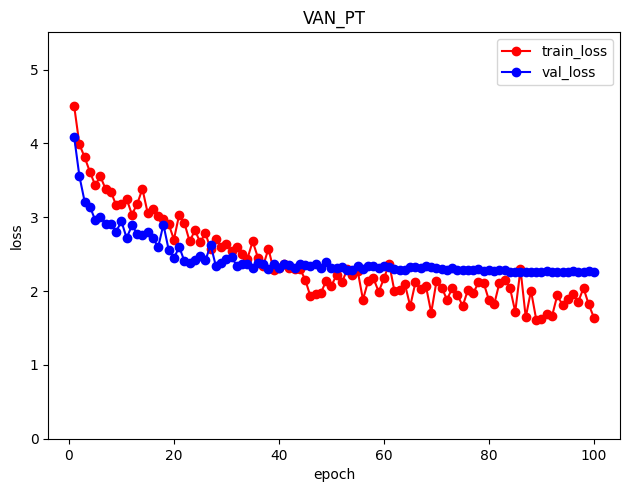

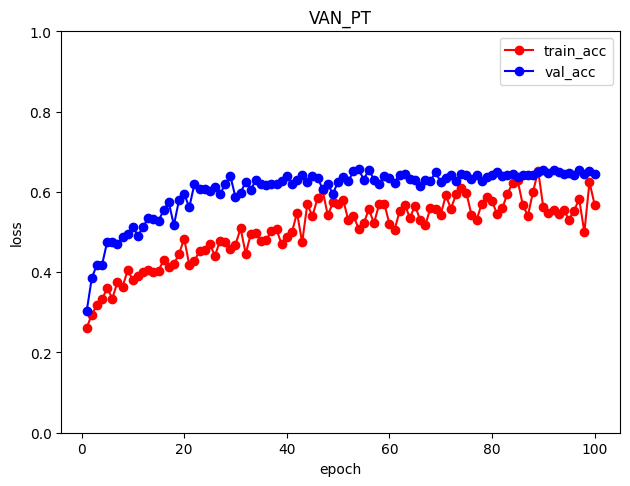

In [32]:
plot_loss(train_losses, val_losses, extractor.name)
plot_acc(train_accs, val_accs, extractor.name)

In [34]:
def predict(test_loader, extractor, classifier, metric, load = False, device = 'cuda'):

    if load:
        if metric == "acc":
            classifier.load_state_dict(torch.load("classifier_weights_valacc-VAN_PT.pth"))
            extractor.load_state_dict(torch.load('extractor_weights_valacc-VAN_PT.pth'))
        elif metric == "loss":
            classifier.load_state_dict(torch.load("classifier_weights_valloss-VAN_PT.pth"))
            extractor.load_state_dict(torch.load('extractor_weights_valloss-VAN_PT.pth'))
    classifier.to(device)
    extractor.to(device)
    extractor.eval()
    classifier.eval()
    
    with open('prediction.txt', 'w') as f:
        for [data,_,_] in test_loader:
            data = data["pixel_values"][0].clone().detach().requires_grad_(True).to(device)

            features = extractor.extract_feat(data)[0]
            output = classifier(features)
            print(output)

            output = transform_vec(output)
            for out in output:
                f.write(" ".join(map(str, out)) + "\n")


predict(test_loader, extractor = VAN_PT(finetune = False).extractor.to(device), 
        classifier = DenseClassifier(256, 100, [7,3,3,4,6,3]), 
        metric = 'acc', load=True)

03/29 13:06:17 - mmengine - INFO - Because batch augmentations are enabled, the data preprocessor automatically enables the `to_onehot` option to generate one-hot format labels.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmclassification/v0/van/van-tiny_8xb128_in1k_20220501-385941af.pth
tensor([[0.2195, 0.0766, 0.0124,  ..., 0.6188, 0.0045, 0.3767],
        [0.0504, 0.0738, 0.3771,  ..., 0.2938, 0.0495, 0.6567],
        [0.1050, 0.0754, 0.1007,  ..., 0.2273, 0.0610, 0.7118],
        ...,
        [0.1989, 0.4236, 0.0256,  ..., 0.1301, 0.1329, 0.7370],
        [0.7711, 0.1446, 0.0067,  ..., 0.6005, 0.0014, 0.3981],
        [0.1136, 0.0999, 0.0166,  ..., 0.1867, 0.0225, 0.7908]],
       device='cuda:0', grad_fn=<CatBackward0>)
tensor([[0.2422, 0.6758, 0.0085,  ..., 0.0093, 0.5430, 0.4477],
        [0.0201, 0.9087, 0.0150,  ..., 0.1418, 0.0409, 0.8173],
        [0.7008, 0.1629, 0.0126,  ..., 0.0289, 0.3141, 0.6569],
        ...,
        [0.2982, 0.4792, 0.04